In [2]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

import warnings
warnings.filterwarnings("ignore")

model_path = ""
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


In [3]:
image_file = ""
prompt='Please describe this image in detail.'
args = type('Args', (), {
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 256,
    "model":model,
    "tokenizer":tokenizer,
    "image_processor":image_processor,
    "output_hidden_states": True,
    "return_dict_in_generate": True,
})()

all_output=eval_model(args)
output_text = tokenizer.decode(all_output['sequences'][0], skip_special_tokens=True)
print(output_text)

The image features a small child standing in a grassy field, wearing a striped shirt and a tie. The child appears to be crying, possibly due to the grass being too long or the outdoor environment. The child is surrounded by a lush green field, which provides a natural and serene setting for the scene.


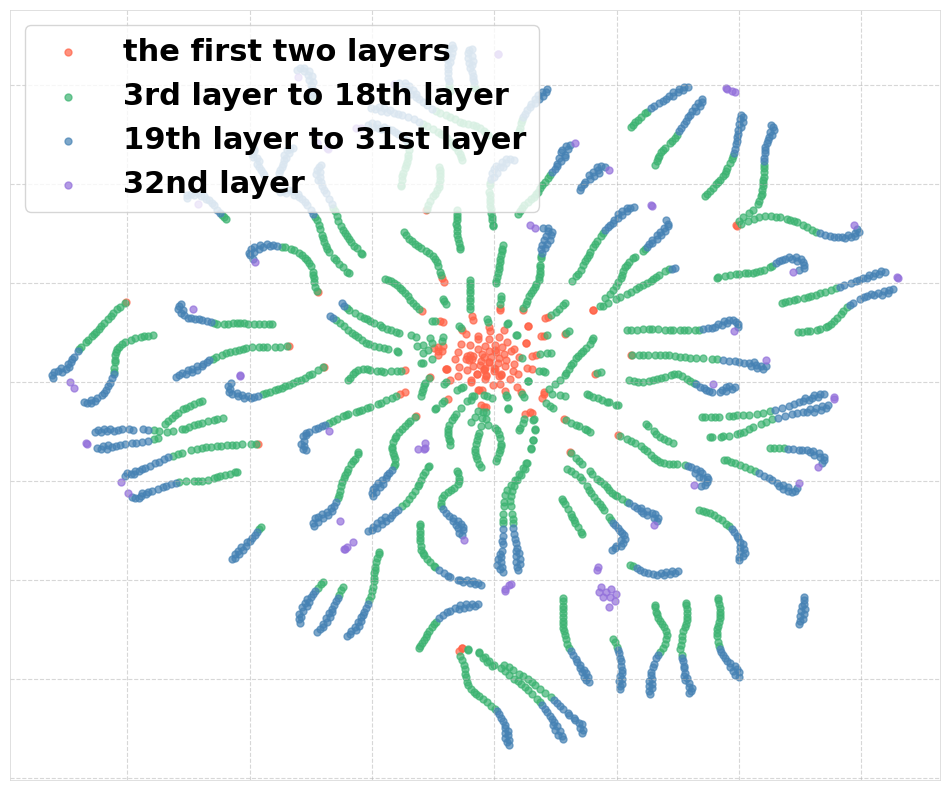

In [4]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MaxAbsScaler

# Extract hidden states from the model output.
hidden_states = all_output["hidden_states"]

# Build a dataset by extracting hidden states from each time step and layer.
# For the first time step, extract the hidden state of the last token.
all_dataset = []
for t in range(len(hidden_states)):
    dataset = []
    for layer in range(len(hidden_states[0])):
        if t == 0:
            # For the first time step, use the last token's hidden state.
            state = hidden_states[t][layer][:, -1, :]
            dataset.append(np.squeeze(state.cpu().numpy()))
        else:
            dataset.append(np.squeeze(hidden_states[t][layer].cpu().numpy()))
    all_dataset.append(dataset)

# Convert the dataset to a NumPy array and remove the first layer (embedding layer)
data_array = np.array(all_dataset)[:, 1:, :]

def generate_colors(cmap_name, num_colors):
    """
    Generate a list of hex color codes using a specified colormap.

    Args:
        cmap_name (str): Name of the Matplotlib colormap (e.g., 'Blues_r').
        num_colors (int): Number of colors to generate.
    
    Returns:
        List[str]: List of hex color codes.
    """
    cmap = plt.get_cmap(cmap_name, num_colors)
    return [to_hex(cmap(i)) for i in range(num_colors)]

# Flatten the data for t-SNE. Here the feature dimension is assumed to be 4096.
data_flat = data_array.reshape(-1, 4096)

# Normalize data using MaxAbsScaler.
scaler = MaxAbsScaler()
data_flat_scaled = scaler.fit_transform(data_flat)

# Create flat labels for plotting.
# Example: first 2 points are label 0, next 16 are label 1, then 13 for label 2, and 1 for label 3.
base_labels = np.concatenate([
    np.repeat(0, 2),
    np.repeat(1, 16),
    np.repeat(2, 13),
    np.repeat(3, 1),
])
labels_flat = np.tile(base_labels, len(hidden_states))

# Create and fit a t-SNE model.
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=2000, random_state=0)
data_tsne = tsne.fit_transform(data_flat_scaled)

# Define label names and a list of colors.
label_names = [
    'the first two layers',
    '3rd layer to 18th layer',
    '19th layer to 31st layer',
    '32nd layer'
]
colors = ['#FF6347', '#3CB371', '#4682B4', '#9370DB', '#FFA07A', '#FFDAB9', '#87CEFA', '#FFB6C1']

# Create the t-SNE scatter plot.
plt.figure(figsize=(12, 10))
for i in range(len(np.unique(labels_flat))):
    plt.scatter(
        data_tsne[labels_flat == i, 0],
        data_tsne[labels_flat == i, 1],
        color=colors[i],
        label=label_names[i],
        s=25,
        alpha=0.7
    )

# Remove axis ticks and labels.
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    left=False,
    right=False,
    labelleft=False
)

# Customize the plot spines (borders)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Add legend and grid.
plt.legend(loc='upper left', prop={'size': 22, 'weight': 'bold'})
plt.grid(True, linestyle='--', alpha=0.5, zorder=0.1)

# Show the plot.
plt.show()
